#  Micrograd from scratch 

## Test Karpathy Micrograd

In [ ]:
! pip3 install micrograd

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
  DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
You should consider upgrading via the '/opt/homebrew/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.


In [1]:
from micrograd.engine import Value 

In [2]:
a = Value(-4.0)
b = Value(2.0)
c = a + b
d = a * b + b**3
c += c + 1
c += 1 + c + (-a)
d += d * 2 + (b + a).relu()
d += 3 * d + (b - a).relu()
e = c - d
f = e**2
g = f / 2.0
g += 10.0 / f

In [3]:
print(f'{g.data:.4f}')

24.7041


In [4]:
g.backward()
a.grad

138.83381924198252

## Micrograd from scratch 

In [5]:
import math 
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline

In [6]:
def f(x):

    return 3*x**2 - 4*x + 5

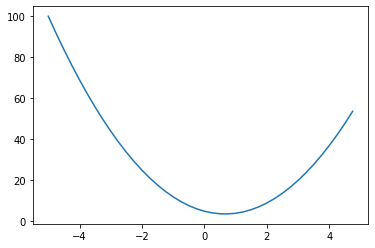

In [7]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [8]:
def der(f, a, h):

    return (f(a+h) - f(a))/h

In [33]:
der(f, 2/3, 0.0000000000001)

-0.004440892098500626

In [34]:
# A more complex case 

a = 2.0 
b = -3.0 
c = 10.0 

d = a*b + c 
print(d)


4.0


In [35]:
h = 0.0001 

#inputs 
a = 2.0 
b = -3.0 
c = 10.0 

d1 = a*b + c 
a += h 
d2 = a*b + c 

print('d1', d1)
print('d2,', d2)
print('slope', (d2-d1)/h)

d1 4.0
d2, 3.999699999999999
slope -3.000000000010772


In [128]:
# Create the micrograd value 

class Value:

    def __init__(self, data, _children=(), _op = '', label = ''):
        self.data = data 
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label 
    def __repr__(self):

        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out =  Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            # Remember that gradients must accumulate
            self.grad += 1.0*out.grad 
            other.grad += 1.0*out.grad 
        
        out._backward = _backward 
        
        return out 
    
    def __radd__(self, other):
        return self + other 
    
    def __neg__(self):
        return -1*self
    
    def __sub__(self, other):
        return self + (-other)
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out =  Value(self.data*other.data, (self, other), "*")
        
        def _backward():
            
            self.grad += other.data*out.grad 
            other.grad += self.data*out.grad 
        
        out._backward = _backward 

        return out 
    
    def __rmul__(self, other):
        return self*other
    
    def __truediv__(self, other):
        return self* other**-1
    
    def __pow__(self, other):
        
        assert isinstance(other, (int, float)), "Only support int or float for now"
        out = Value(self.data**other, (self, ), f"**{other}")
        
        def _backward():
            
            self.grad += (other*self.data**(other-1))*out.grad
        
        out._backward = _backward 
        
        return out 


        
        return out 
    
    def exp(self):
        x = self.data 
        out = Value(math.exp(x), (self, ), "exp")
        
        def _backward():
            
            self.grad += out.data*out.grad
        
        out._backward = _backward 
        
        return out 

    
    def tanh(self):
        x = self.data 
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), "tanh")

        def _backward():
            
            self.grad += (1 - out.data**2)*out.grad
        
        out._backward = _backward 
        
        return out 

    
    def backward(self):
        
        topo = []
        visited = set()
        def build_topo(v):
          if v not in visited:
            visited.add(v)
            for child in v._prev:
              build_topo(child)
            topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [133]:
a = Value(20)
b = Value(10)
-b

Value(data=-10)

In [29]:
# Visualize the compute graph 

from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{%s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot


In [136]:

# Two input neuron 

x1 = Value(2.0, label = 'x1') 
x2 = Value(0.0,label = 'x2') 

# Weights 
w1 = Value(-3.0, label = 'w1') 
w2 = Value(1.0, label = 'w2') 
b = Value(6.8813735870195432, label = 'b')

x1w1 = w1*x1
x1w1.label = 'x1w1'
x2w2 = w2*x2 
x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2 
x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b 
n.label = 'n'
e = (2*n).exp() 
o = (e-1)/(e+1)
o.label = "o"
o.backward()


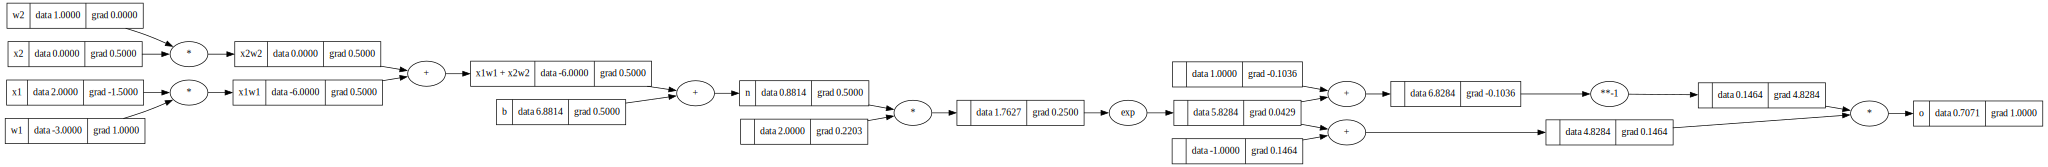

In [137]:
draw_dot(o)

In [138]:
import torch 

ModuleNotFoundError: No module named 'torch'